In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from tqdm.notebook import tqdm

import gymnasium as gym
from minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper

In [4]:
device = 'cuda:2'

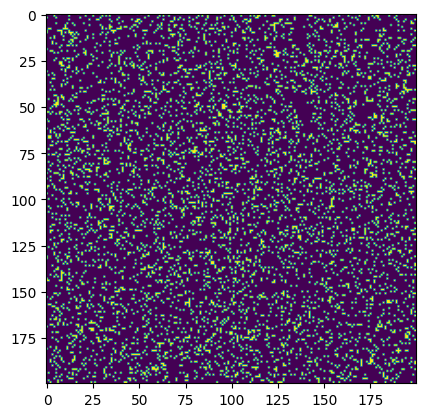

In [5]:
map_lava = torch.rand(200, 200)<.15
x_lava = map_lava.nonzero()
plt.imshow(map_lava)

In [6]:
class MyMiniGrid():
    def __init__(self, limit=100):
        super().__init__()
        self.limit = limit
        self.offset = 10

        self.action2vec = {
            0: torch.tensor([1, 0]),
            1: torch.tensor([0, 1]),
            2: torch.tensor([-1, 0]),
            3: torch.tensor([0, -1]),
        }

        self.reset()
        
    def reset(self, state=None):
        if state is None:
            state = (torch.zeros(2, dtype=torch.int32), False)
        self.state = state
        obs, reward, done, info = self.calc_obs(), 0, False, {}
        return self.state, obs, 0, False, info
        
    def step(self, action):
        if isinstance(action, torch.Tensor):
            action = action.item()
        xy, dead = self.state
        if not dead:
            xy = torch.clamp(xy + self.action2vec[action], min=0, max=self.limit)
            dead = dead or map_lava[xy[0]+self.offset, xy[1]+self.offset].item()
        self.state = (xy, dead)
        obs, reward, done, info = self.calc_obs(), 0, dead, {}
        return self.state, obs, reward, done, info
    
    def calc_obs(self, state=None):
        if state is None:
            state = self.state
        xy, dead = state
        if dead: # give a default observation if dead
            return torch.zeros(12)-2.
        else:
            a = (xy-self.limit/2)/self.limit*4
            b = map_lava[xy[0]-1+self.offset:xy[0]+2+self.offset, xy[1]-1+self.offset:xy[1]+2+self.offset]
            obs = torch.cat([a.flatten(), b.flatten(), torch.tensor(dead).float()[None]])
            return obs


In [7]:
env = MyMiniGrid()
env.reset()

((tensor([0, 0], dtype=torch.int32), False),
 tensor([-2., -2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 0,
 False,
 {})

In [8]:
def tensor_stack(a):
    if isinstance(a, torch.Tensor):
        return a
    elif isinstance(a, list):
        return torch.stack([tensor_stack(i) for i in a])
    
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer
    
class ImitationExplorer(nn.Module):
    def __init__(self):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(12, 10)),
            nn.Tanh(),
            layer_init(nn.Linear(10, 10)),
            nn.Tanh(),
            layer_init(nn.Linear(10, 1), std=1.0),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(12, 10)),
            nn.Tanh(),
            layer_init(nn.Linear(10, 10)),
            nn.Tanh(),
            layer_init(nn.Linear(10, 4), std=0.01),
        )
        self.opt = torch.optim.Adam(self.parameters(), lr=1e-4)
        self.losses_all = []

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        logits = self.actor(x)
        probs = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(x)
    
    def update_policy(self, ge, n_steps, batch_size, viz=False):
        obs_good = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_good])
        actions_good = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_good])
        obs_good = obs_good.reshape(-1, obs_good.shape[-1])
        actions_good = actions_good.reshape(-1)

        obs_bad = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_bad])
        actions_bad = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_bad])
        obs_bad = obs_bad.reshape(-1, obs_bad.shape[-1])
        actions_bad = actions_bad.reshape(-1)
        # print(obs_bad.shape)
        # print(obs_good.shape)


        losses = []
        for i_batch in range(n_steps):
            idx_good = torch.randperm(len(obs_good))[:batch_size//2]
            idx_bad = torch.randperm(len(obs_bad))[:batch_size//2]
            batch_obs_good = obs_good[idx_good].to(device)
            batch_obs_bad = obs_bad[idx_bad].to(device)
            batch_actions_good = actions_good[idx_good].to(device)
            batch_actions_bad = actions_bad[idx_bad].to(device)

            _, log_probs_good, entropy, _ = self.get_action_and_value(batch_obs_good, batch_actions_good)
            _, log_probs_bad, entropy, _ = self.get_action_and_value(batch_obs_bad, batch_actions_bad)

            loss = log_probs_bad.mean()-log_probs_good.mean()

            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            losses.append(loss.item())


        batch_actions = torch.cat([batch_actions_good, batch_actions_bad], dim=0)
        log_probs = torch.cat([log_probs_good, log_probs_bad], dim=0)

        self.losses_all.extend(losses)
        if viz:
            plt.plot(losses)
            plt.show()
            for i in range(4):
                print(f'Action {i}')
                print(log_probs[batch_actions==i].mean().item())

# do_training(10, 2048)
class RandomExplorer(nn.Module):
    def __init__(self):
        super().__init__()
        
    def get_action_and_value(self, x, action=None):
        logits = torch.zeros(x.shape[:-1]+(4,))
        probs = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), 0.

In [9]:
def obs2latent(env, state_sim, obs):
    xy, dead = state_sim
    if dead: # dead
        return (0, 0)
    else:
        return tuple(xy.tolist())

class Node():
    def __init__(self, parent, traj, state_sim, obs, latent):
        self.parent = parent
        self.children = []
        
        self.traj = traj

        self.state_sim = state_sim
        self.obs = obs

        self.latent = latent
        
    def get_full_trajectory(self):
        if self.parent is None:
            return self.traj
        return self.parent.get_full_trajectory() + self.traj

class Archive(list):
    def __init__(self, node_root):
        # self.goexplore = goexplore
        self.node_root = node_root
        self.cell2node = {}
        from collections import defaultdict
        # self.cell2n_seen = {}
        self.cell2n_seen = defaultdict(lambda : 0)
        
        self.add_node(node_root)
        
    def add_node(self, node):
        self.cell2node[node.latent] = node
        # self.cell2n_seen[node.latent] = 0
        self.append(node)
        if node.parent:
            node.parent.children.append(node)
    def add_if_better(self, node):
        cells = set([node.latent for node in self])
        if node.latent in cells:
            node_old = self.cell2node[node.latent]
            if len(node.get_full_trajectory())<len(node_old.get_full_trajectory()):
                self.add_node(node)
            return False
        else:
            self.add_node(node)
            return True
        
class GoExplore():
    def __init__(self, env, explorer):
        self.env = env
        self.explorer = explorer

        self.explorer.goexplore = self
        
        self.state2latent = lambda state, obs: obs2latent(self.env, state, obs)
        
        state_sim, obs, reward, done, info = self.env.reset()
        latent = self.state2latent(state_sim, obs)
        node_root = Node(None, [], state_sim, obs, latent)
        self.archive = Archive(node_root)
        
        self.trajs_good = []
        self.trajs_bad = []

    def select_node(self):
        cells = list(self.archive.cell2node.keys())
        n_seen = np.array([self.archive.cell2n_seen[cell] for cell in cells])
        p = 1./np.sqrt(n_seen+1)
        p = p/p.sum()
        cell = cells[np.random.choice(len(cells), p=p)]
        node = self.archive.cell2node[cell]
        return node

    def explore_from(self, node_start, len_traj):
        traj = [] # list of tuples (state, obs, action, log_probs, reward)
        # state_sim, obs = node_start.state_sim, node_start.obs
        state_sim, obs, reward, done, info = env.reset(node_start.state_sim)
        latents = set()
        for i_trans in range(len_traj):
            latent = self.state2latent(state_sim, obs)
            latents.add(latent)
            with torch.no_grad():
                action, log_prob, _, _ = self.explorer.get_action_and_value(obs.to(device))
                action, log_prob = action.cpu(), log_prob.cpu()
                
            state_sim_next, obs_next, reward, done, info = self.env.step(action.item())
            traj.append((state_sim, obs, done, action, log_prob, reward))
            state_sim, obs = state_sim_next, obs_next
            # if done:
                # break

        latent = self.state2latent(state_sim, obs)
        latents.add(latent)
        return Node(node_start, traj, state_sim, obs, latent), latents, done

    def step_explore(self, n_trajs, len_traj):
        nodes = []
        dones = []
        for i_traj in range(n_trajs):
            node_start = self.select_node()
            self.env.reset(node_start.state_sim)
            node_end, latents, done = self.explore_from(node_start, len_traj)
            nodes.append(node_end)
            dones.append(done)
            
            for latent in latents:
                self.archive.cell2n_seen[latent] += 1
            better = self.archive.add_if_better(node_end)
            if better:
                self.trajs_good.append(node_end.traj)
            else:
                self.trajs_bad.append(node_end.traj)
        return nodes, latents, np.array(dones).mean()
    

In [28]:
env = MyMiniGrid()
explorer = RandomExplorer().to(device)
# explorer = ImitationExplorer().to(device)
ge = GoExplore(env, explorer)
dones = []
archive_size = []
for i in tqdm(range(20)):
    _, _, done = ge.step_explore(100, 10)
    dones.append(done)
    archive_size.append(len(ge.archive))
    if isinstance(explorer, ImitationExplorer):
        explorer.update_policy(ge, n_steps=100, batch_size=10000)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Results for  RandomExplorer


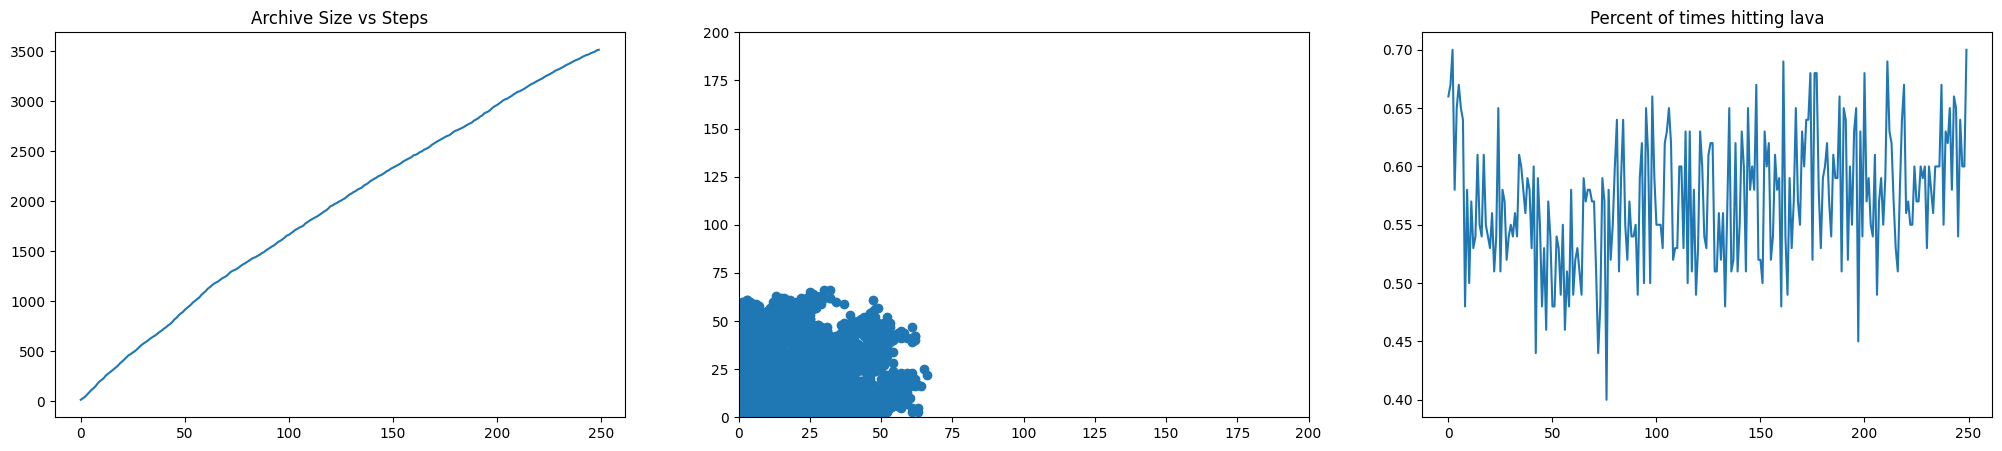

  0%|          | 0/250 [00:00<?, ?it/s]

Results for  ImitationExplorer


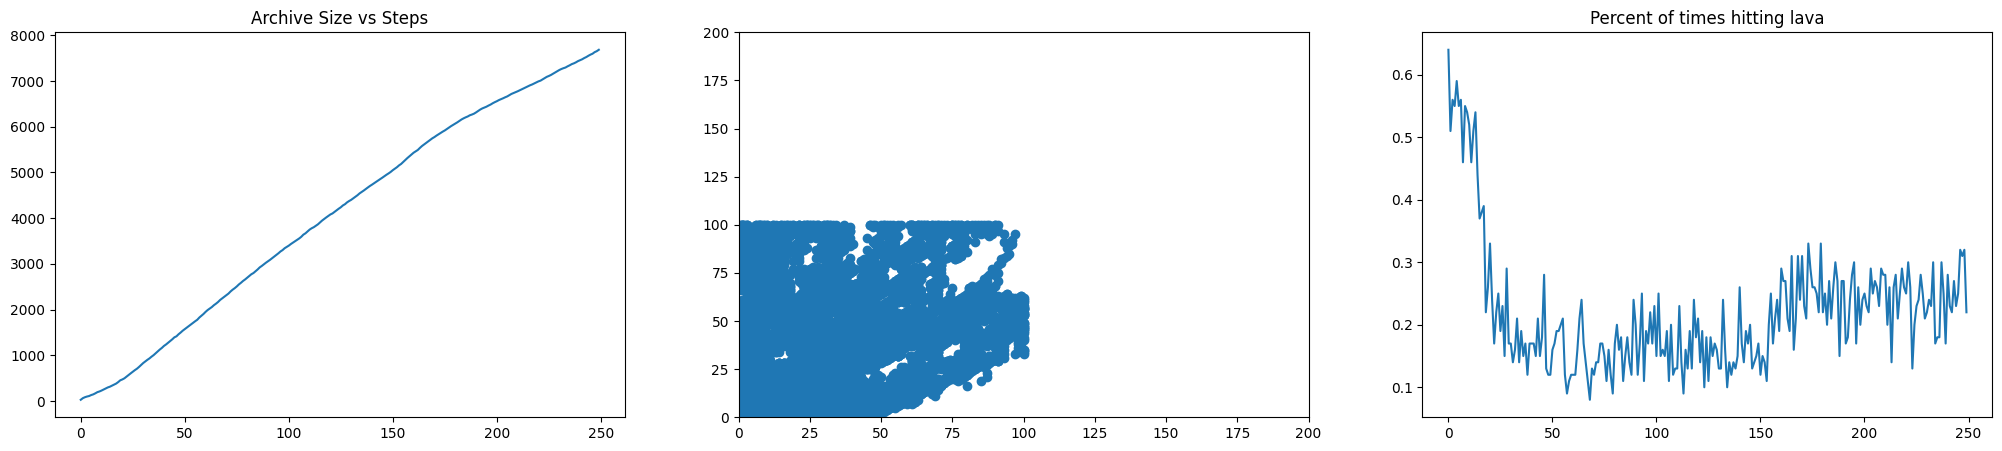

In [38]:
for Explorer in [RandomExplorer, ImitationExplorer]:
    env = MyMiniGrid()
    explorer = Explorer().to(device)
    ge = GoExplore(env, explorer)
    dones = []
    archive_size = []
    for i in tqdm(range(250)):
        _, _, done = ge.step_explore(100, 10)
        dones.append(done)
        archive_size.append(len(ge.archive))
        if isinstance(explorer, ImitationExplorer):
            explorer.update_policy(ge, n_steps=100, batch_size=10000)
    print('Results for ', explorer.__class__.__name__)
    x = np.array([node.latent for node in ge.archive])
    plt.figure(figsize=(25, 5))
    plt.subplot(131)
    plt.plot(archive_size)
    plt.title('Archive Size vs Steps')
    plt.subplot(132)
    plt.scatter(*x.T)
    plt.xlim(0, 200); plt.ylim(0, 200)
    plt.subplot(133)
    plt.plot(dones)
    plt.title('Percent of times hitting lava')
    plt.show()

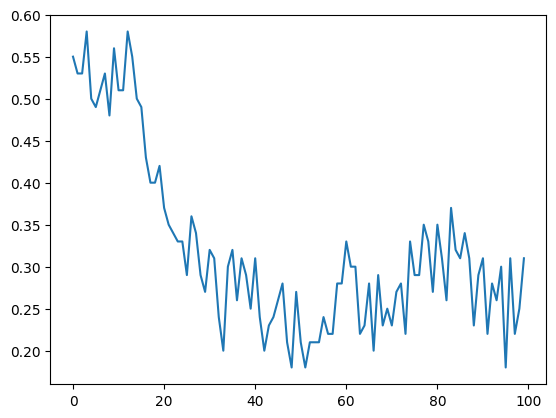

In [138]:
plt.plot(dones)

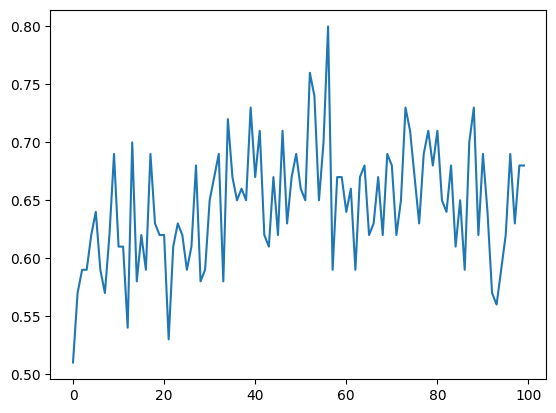

In [136]:
plt.plot(dones)

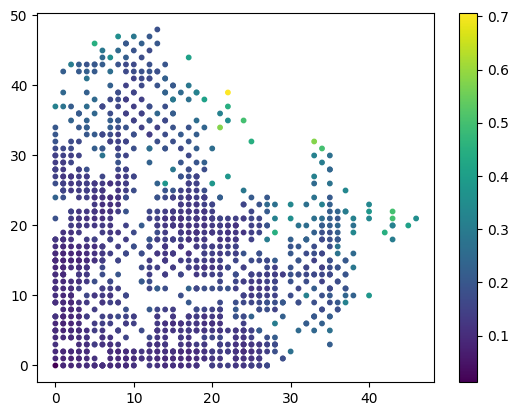

In [130]:
x = np.array([node.latent for node in ge.archive])
c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
c = 1./np.sqrt(c+1)
plt.scatter(*x.T, c=c, s=10.)
plt.colorbar()

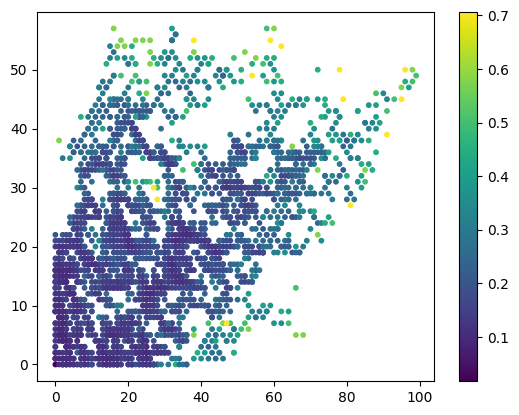

In [139]:
x = np.array([node.latent for node in ge.archive])
c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
c = 1./np.sqrt(c+1)
plt.scatter(*x.T, c=c, s=10.)
plt.colorbar()

In [165]:
x = np.array([node.latent for node in ge.archive])
c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
x.shape, c.shape

((2736, 2), (2736,))

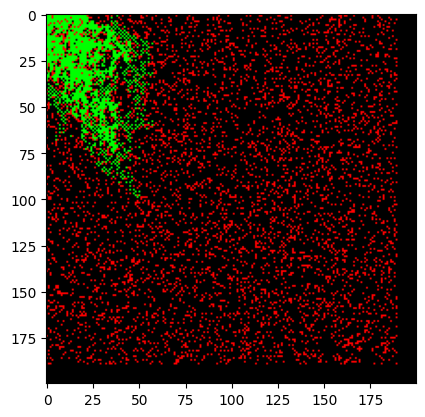

In [185]:
img = torch.zeros(200, 200, 3)
img[x[:, 0], x[:, 1], 1] += 1.
img[:190, :190, 0] += map_lava[10:, 10:]
plt.imshow(img)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

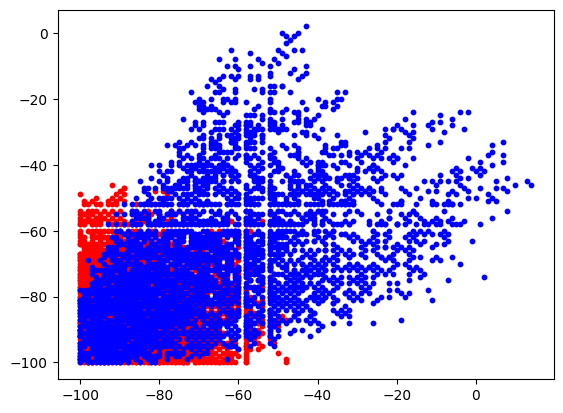

In [305]:
env = MyMiniGrid()
for Explorer in [RandomExplorer, ImitationExplorer]:
    explorer = Explorer().to(device)
    ge = GoExplore(env, explorer)
    for i in tqdm(range(50)):
        ge.step_explore(100, 10)
        if isinstance(explorer, ImitationExplorer):
            explorer.update_policy(ge, n_steps=100, batch_size=10000)
    x = np.array([node.latent for node in ge.archive])
    c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
    c = 1./np.sqrt(c+1)
    # plt.scatter(*x.T, c=c, s=10.)
    plt.scatter(*x.T, c='r' if isinstance(explorer, RandomExplorer) else 'b', s=10.)
    # plt.colorbar()
    # plt.show()

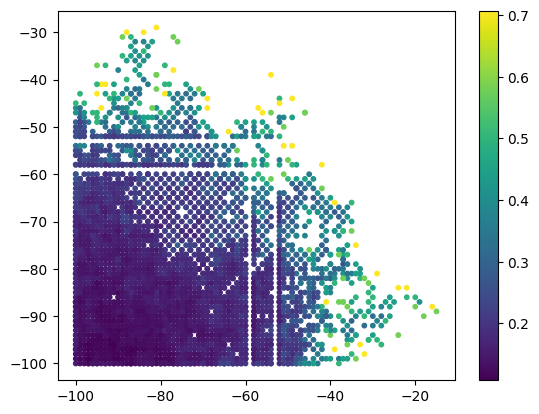

In [265]:
x = np.array([node.latent for node in ge.archive])
c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
c = 1./np.sqrt(c+1)
plt.scatter(*x.T, c=c, s=10.)
plt.colorbar()

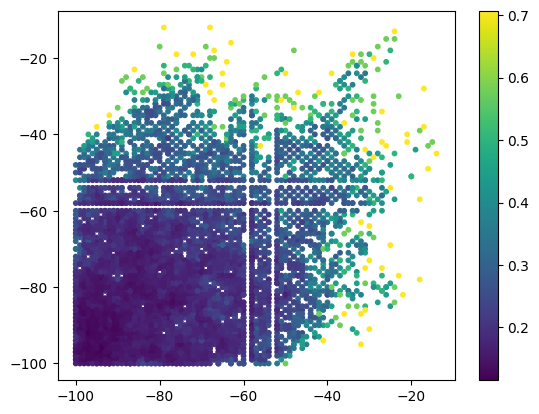

In [262]:
x = np.array([node.latent for node in ge.archive])
c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
c = 1./np.sqrt(c+1)
plt.scatter(*x.T, c=c, s=10.)
plt.colorbar()

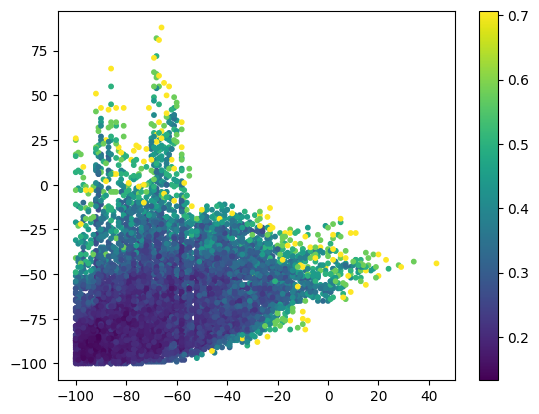

In [279]:
x = np.array([node.latent for node in ge.archive])
c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
c = 1./np.sqrt(c+1)
plt.scatter(*x.T, c=c, s=10.)
plt.colorbar()

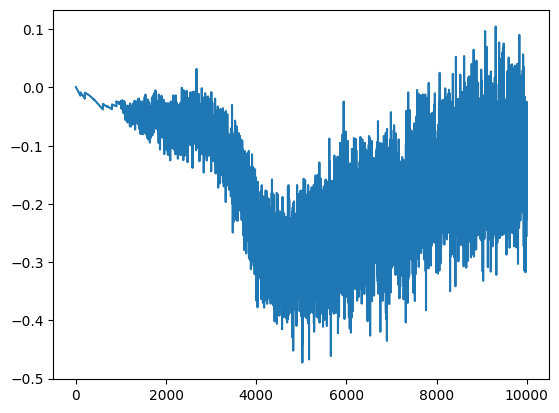

In [282]:
plt.plot(explorer.losses_all)

In [291]:
actions, log_probs, _, _, = explorer.get_action_and_value(torch.stack([node.obs for node in ge.archive]).to(device))

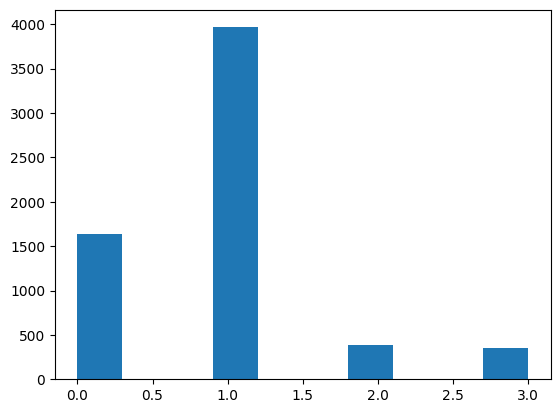

In [295]:
plt.hist(actions.detach().cpu().numpy());

  0%|          | 0/10 [00:00<?, ?it/s]

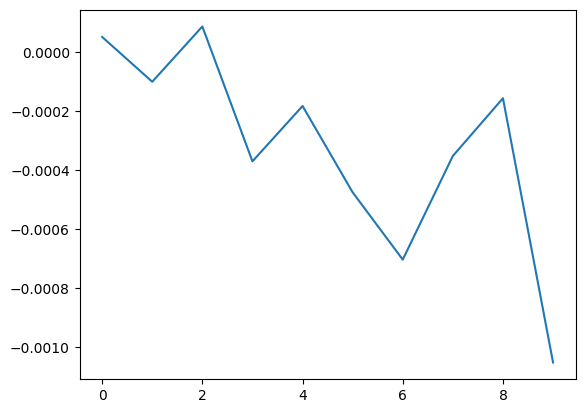

Action 0
-1.383995532989502
Action 1
-1.3778831958770752
Action 2
-1.3862355947494507
Action 3
-1.3971469402313232


In [226]:
def tensor_stack(a):
    if isinstance(a, torch.Tensor):
        return a
    elif isinstance(a, list):
        return torch.stack([tensor_stack(i) for i in a])
    
def update_policy(ge, n_steps, batch_size, viz=False):
    obs_good = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_good])
    actions_good = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_good])
    obs_good = obs_good.reshape(-1, obs_good.shape[-1])
    actions_good = actions_good.reshape(-1)
    
    obs_bad = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_bad])
    actions_bad = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_bad])
    obs_bad = obs_bad.reshape(-1, obs_bad.shape[-1])
    actions_bad = actions_bad.reshape(-1)
    # print(obs_bad.shape)
    # print(obs_good.shape)
    
    
    explorer = Explorer().to(device)
    opt = torch.optim.Adam(explorer.parameters(), lr=1e-4)
    
    losses = []
    for i_batch in tqdm(range(n_steps)):
        idx_good = torch.randperm(len(obs_good))[:batch_size//2]
        idx_bad = torch.randperm(len(obs_bad))[:batch_size//2]
        batch_obs_good = obs_good[idx_good].to(device)
        batch_obs_bad = obs_bad[idx_bad].to(device)
        batch_actions_good = actions_good[idx_good].to(device)
        batch_actions_bad = actions_bad[idx_bad].to(device)
        
        _, log_probs_good, entropy, _ = explorer.get_action_and_value(batch_obs_good, batch_actions_good)
        _, log_probs_bad, entropy, _ = explorer.get_action_and_value(batch_obs_bad, batch_actions_bad)
        
        loss = log_probs_bad.mean()-log_probs_good.mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
        
    
    batch_actions = torch.cat([batch_actions_good, batch_actions_bad], dim=0)
    log_probs = torch.cat([log_probs_good, log_probs_bad], dim=0)
    
    if viz:
        plt.plot(losses)
        plt.show()
        for i in range(4):
            print(f'Action {i}')
            print(log_probs[batch_actions==i].mean().item())

do_training(10, 2048)